# Cut-it

David Alsina, Isabela Cáceres, y Camilo Martinez

En este proyecto la idea es desarrollar un algorithmo de segmentación de imagenes a color, utilizando el Mean  Sift y partición de grafos. Ustedes deben realizar la implementación tanto del algoritmo de mean-shift como el de grafos. Para esto pueden seguir las indicaciones explicadas a continuación.

## Algoritmo de mean-shift

Este algoritmo tiene como datos de entrada el tamaño de la region de busqueda (radio de busqueda). El algoritmo toma cada pixel de la imagen, expresado en un espacio de color LUV, RGB o HSI, deberian hacerlo generico para que el algoritmo realice la segmentación, independientemente del tipo de formato de color utilizado.

El algoritmo consiste en los siguientes pasos:
1. para cada pixel, determinar un entorno de radio r, radio de búsqueda.
2. Calcular el centro de masa de los puntos dentro del radio. 
3. Encontrar los elementos en un radio r alrededor del centro de masa calculado en el paso anterior.
4. Repetir el paso 3 hasta convergencia.
5. repetir desde el paso 2 para cada uno de los puntos que representa la imagen.
6. Identificar cuantos modos hay en la imagen. Los modos son los puntos a los que convergen los pixeles de la imagen.
7. Todos los pixeles que convergen a un modo se agrupan en un mismo conjunto. Cada uno de estos segnmentos es una region conexa de pixeles en la imagen.

## Algoritmo basado en grafos.

Este algoritmo se basa en el clustering espectral. Junto a este proyecto pueden encontrar un paper qu eexplica en que consiste este método. En si el proceso a realizar es el siguiente:

1. Construir el grafo de la imagen.
2. Encontrar el La matrix Laplaciana del grafo.
3. Realizar una descomposicion en valores singulares de la imagen, buscando el eigenvector asociado al segundo eigenvalor más pequeño de la imagen.
4. Graficar este eigenvector organizando los valores de menor a mayor (deben hacer tracking de los indices al organizar este vector)
5. Los elementos (posiciones del eigenvector) que tienen un valor similar, corresponden a elementos conexos en la imagen.
6. Determine umbrales para segmentar la imagen en regiones conexas.


Para la entrega del proyecto deben proporcionar lo siguiente:

1. Implementación de los algoritmos.
2. Prueba de los algoritmos utilizando diferentes imagenes y representaciones en espacio de color.
3. Gráficas de los clusters encontrados (modos y sus regiones), asi como de los eigenvectores.
4. Discusion de la implementación.
5. Discusion de los resultados obtenidos, ventajas y desventajas de cada método.
6. Posibles mejoras.

Para la implementación con grafos tengan en cuenta que se debe realizar la descomposicion en valores singulares de una matrix tamaño $N\times N$, donde $N$ res el número de pixeles en la imagen. Como esto es computacionalmente muy costoso, hay dos opciones. La primera es usar imagenes pequeñas, pero estas imagenes serían tal vez demasiado pequeñas (tamaños inferiores a $100\times 100$). Otra opción es hacer que cada nodo no sea un pixel, sino un superpixel, de esta forma se puede reducir bastante la complejidad del algoritmo.

El proyecto lo deben entregar el **Lunes 9 de Mayo a las 11:59 p.m**. Se pueden hacer en grupos de dos personas y admito un grupo de tres personas. Mucha suerte!!

In [1]:
!pip install opencv-python
# apt-get update && apt-get install -y python3-opencv

In [2]:
#para trabajar la imagen :D
import cv2
import numpy as np
from matplotlib import pyplot as plt
import copy
from scipy import ndimage
import pandas as pd

from skimage import data, segmentation, color

#para paralelizar
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm

#numero de nucleos disponibles - 1
num_cores = multiprocessing.cpu_count() - 1 

https://www.geeksforgeeks.org/image-segmentation-using-k-means-clustering/ 


In [3]:
def preprocess_im(original_im: np.ndarray,
                  scale_percent = 30.0,
                  kernel_size = 3, 
                  proportion_of_superpix = 0.05):
    
    """
        Función de preprocesado de la imagen. 
    """
    
    # quitamos algunas componentes de ruido con un filtro de media 
    # y tamaño de kernel nxn
    original_im = cv2.medianBlur(original_im,
                                 kernel_size).astype('uint8')
    
    # ancho y alto escalados
    width = int(original_im.shape[1] * scale_percent / 100)
    height = int(original_im.shape[0] * scale_percent / 100)
    
    # redimensiona el tamaño de la imagen
    resized = cv2.resize(img, (width, height), interpolation = cv2.INTER_AREA)

    # calcula el numero necesario de superpixeles
    nsegments = int((width*height)* proportion_of_superpix) + 1
    
    # obtiene las etiquetas de los superpixeles
    labels1 = segmentation.slic(resized,
                                compactness = 30,
                                n_segments = nsegments,
                                start_label = 1)
    
    #reconstruye la imagen superpixelada
    img_segment = color.label2rgb(labels1,
                                  resized,
                                  kind='avg',
                                  bg_label=0).astype('uint8')

    return resized, img_segment

In [4]:
img = cv2.imread('casitas.jpeg')
#img = cv2.imread('eye.jpg')
#img = cv2.imread('perrito.jpg')
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

img, superpix_im = preprocess_im(original_im = img,
                                 scale_percent = 30.0, 
                                 kernel_size = 3, 
                                 proportion_of_superpix = 0.05)

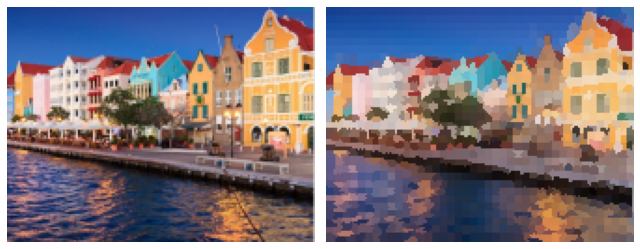

In [5]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1,
                       ncols=2,
                       sharex=True, sharey=True,
                       figsize=(9, 6))

ax[0].imshow(img)
ax[1].imshow(superpix_im)

for a in ax:
    a.axis('off')

plt.tight_layout()

In [6]:
def gen_window_indx(img: np.ndarray,
                    center: tuple,
                    radious: float) -> tuple:
    """
        genera lista de indices de filas y de columnas que
        corresponden a la ventana (circulo)
    """
    
    rows=[]
    cols= []
    r = radious
    h, k = center
    x0, y0 = h - r, k - r
    for i in range(2*r+1):
        x= x0+i
        if (x < 0) or (x > img.shape[0]-1): continue
        for j in range(2*r+1):
            y = y0+j
            if y < 0 or (y > img.shape[1]-1): continue
            if ((x-h)**2 + (y-k)**2 <= r**2):
                #img[x,y]=0
                rows.append(x)
                cols.append(y)
                
    return rows, cols

In [7]:
def isolate_window(img: np.ndarray,
                   center: tuple,
                   radious: float) -> np.ndarray:
    """
        Aisla la ventana en la imagen. Es decir, hace todo cero menos los
        valores que estan dentro de la ventana (dentro del circulo)
    """
    img_copy = copy.deepcopy(img)
    rows, cols = gen_window_indx(img_copy, center, radious)

    rows = np.array(rows).astype("int32")
    cols = np.array(cols).astype("int32")

    img_copy[rows,cols,0] = 0
    img_copy[rows,cols,1] = 0
    img_copy[rows,cols,2] = 0

    img_copy = img - img_copy

    return img_copy

(57, 84, 0)


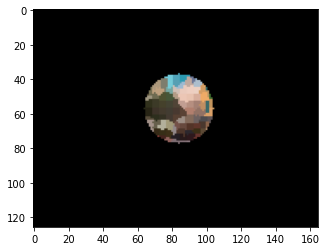

In [9]:
#img_ch = img[:,:,0]

# calcula el centro de masa de la imagen
window_center = ndimage.center_of_mass(superpix_im)
window_center = tuple(np.floor(window_center).astype(np.int32))

print(window_center)
plt.imshow( isolate_window(img = superpix_im,
                           center = (window_center[0],
                                     window_center[1]),
                           radious= 20) )
plt.show()

In [10]:
def indices_array(n: int,
                  m: int,
                  nsuper_pix: int) -> np.ndarray:

    """
    
    Input:
            n -> número de filas
            m -> número de columnas
            nsuper_pix -> numero final de super 
                          pixeles que se van a hacer.  
            
        Saca los indices de los centros, 
        retorna una matrix () x () x 2
        donde la primera capa son indices de las filas.
        y la segunda capa son indices de las columnas
    """
    
    # cuadro el numero de pasos en las filas 
    # para que el largo de el vector 'r'
    # sea sqrt(nsuper_pix) e igual para las columnas 
    # de modo que en total hayan nsuper_pix.
    
    nelem = np.ceil(np.sqrt(nsuper_pix)).astype('int32')
    
    r = np.linspace(0, n, num  = nelem)
    r2 = np.linspace(0, m, num = nelem)
    
    npoints = r.shape[0]
    mpoints = r2.shape[0]

    #print(npoints*mpoints)
    
    out = np.empty((npoints,mpoints,2),dtype=int)
    
    out[:,:,0] = r[:,None]
    out[:,:,1] = r2
    
    return out

In [11]:
def find_mode(img: np.ndarray,
              center: tuple,
              radious: float,
              max_iter: int,
              e_tol: float):

    """
    Función que encuentra el modo para un centro dado.
    
        img      -> imagen a la que se le va a buscar el centro
                    de masa.
        radio    -> radio de busqueda para trabajar y encontrar el
                    centro de masa.
        center   -> tupla de la forma (row, col).
        max_iter -> numero máximo de iteraciones.
        e_tol    -> valor umbral para el error, una vez el error
                    está por debajo de este umbral, se puede parar la 
                    iteración.
    """

    
    # coordenadas centrales
    window_center_of_mass = center
    
    #contador de numero de iteraciones
    count = 0
    
    # inicialización por defecto del error
    # para permitir que funcione el while loop
    e = e_tol*2

    while (count <= max_iter) and (e >= e_tol):
        
        img_window = isolate_window(img = img,
                                    center = (window_center_of_mass[0], 
                                              window_center_of_mass[1]),
                                    radious = radious)

        mass_center = ndimage.center_of_mass(img_window)
        e = np.linalg.norm(np.array(window_center_of_mass) - np.array(mass_center[:-1]))

        #print(e)
        #print(mass_center)

        window_center_of_mass = tuple(np.floor(mass_center[:-1]).astype(np.int32))
        count+=1

    return (center, window_center_of_mass)
        

In [12]:
def find_modes(img: np.ndarray,
               radious: float,
               nsuper_pix: int,
               max_iter: int,
               e_tol: float):
  
    """
    Función que encuentra el modo para la cantidad de super pixeles 
    requeridos.
    
        img        -> imagen a la que se le va a buscar el centro
                      de masa.
        radio      -> radio de busqueda para trabajar y encontrar el
                      centro de masa en torno a cada super pixel.
        nsuper_pix -> número de super pixeles a crear para buscar los 
                      modos de la imagen.
        max_iter   -> número máximo de iteraciones para encontrar el modo
                      de cada super pixel.
        e_tol      -> valor umbral para el error, una vez el error
                      está por debajo de este umbral, se puede parar la 
                      iteración de búsqueda del modo de cada superpixel.
    """

    # numero de filas, columnas y cantidad de canales
    nrows, ncols, nchannels = img.shape

    centers = indices_array(nrows, ncols, nsuper_pix=nsuper_pix)
    centers_list = []
    
    for center in centers.reshape(-1, 2):
            centers_list.append(tuple(center))
        
    
    #envía el proceso en paralelo para hacer los calculos requeridos
    print("Iniciando paralelización ...")
    print("Usando ", num_cores, " hilos")
 
    #print(centers_list)
    centers = {}
    
    processed_list = Parallel(n_jobs=num_cores)(delayed(find_mode)(img,
                                                                   i_center,
                                                                   radious,
                                                                   max_iter, 
                                                                   e_tol) for i_center\
                                                                          in\
                                                                          centers_list)
            
    for initial_center, final_center in processed_list:        
        centers[tuple(initial_center)] = final_center
    
    return centers

In [14]:
# radio de búsqueda
radious = 5

#porcentaje de la cantidad total de pixeles 
#que van a ser usados para crear super pixeles
percentaje = 0.08

#numero de super pixeles para hacer la segmentación
npix = int(superpix_im.shape[0] * superpix_im.shape[1] * percentaje)
print(npix)

modes = find_modes(img = superpix_im,
                   radious = radious,
                   nsuper_pix = npix, 
                   max_iter = 60, 
                   e_tol = 0.05)
len(modes.keys())

1663
Iniciando paralelización ...
Usando  7  hilos


1681

In [15]:
#numero final de modos encontrados
nmodes = len(pd.DataFrame.from_dict(modes, orient='index').drop_duplicates())
nmodes

947

In [16]:
def draw_image_from_modes(original_im: np.ndarray,
                          modes: dict,
                          radiuos: float):
    
    """
        Con base a las etiqueas guardadas en el diccionario modes
        y a la información del radio rellena la imagen 
        con los colores encontrados finalmente
    """
    
    
    im = np.zeros(img.shape).astype("uint8")


    for i_centr, f_centr in modes.items():

        im[i_centr[0] - (radiuos//2)-1:i_centr[0]+(radiuos//2),
           i_centr[1] - (radiuos//2)-1:i_centr[1]+(radiuos//2), :] = original_im[f_centr[0], f_centr[1], :]

    return im

In [20]:
def plot_for_comparisson(original_im: np.ndarray,
                         superpix_im: np.ndarray,
                         modes: dict, 
                         radious: float):

    """
        original_im        -> imagen original.
        superpix_im        -> imagen a la que se le aplicaron super pixeles.
        modes              -> diccionario que guarda el mapeo entre super pixel
                              y su modo encontrado.
    """
    
    # crea la imagen procesada con meanshift.
    processed_im = draw_image_from_modes(original_im = img,
                                         modes = modes, 
                                         radiuos = radious)

    fig, axs = plt.subplots(nrows=1,
                            ncols=3,
                            figsize=(10,6), 
                            dpi=200)
    fig.tight_layout(pad=4) 

    #plot de la imagen superpixelada
    axs[0].imshow(superpix_im)
    axs[0].set_title("Imagen de superpixeles",
                     pad = 5)
    
    #plot imagen meanshift
    axs[1].imshow(processed_im)
    axs[1].set_title("Imagen de superpixeles\n procesada con\n meanshift",
                     pad = 5)
    
    #plot imagen original
    axs[2].imshow(img)
    axs[2].set_title("Imagen original", 
                     pad = 5)

    
    plt.show()

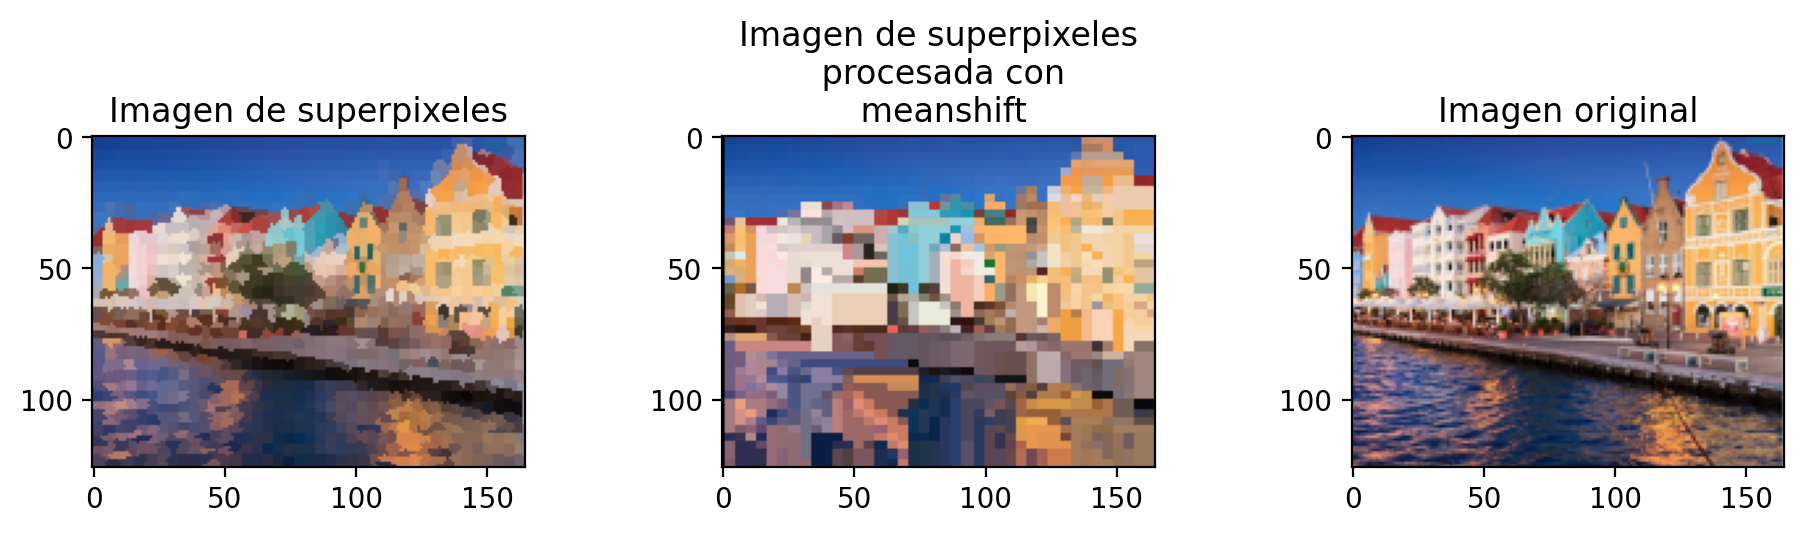

In [22]:
%matplotlib inline
plot_for_comparisson(original_im  = img, 
                     superpix_im = superpix_im,
                     modes = modes, 
                     radious = radious)

## Repetimos proceso para otra img

In [29]:
#img = cv2.imread('casitas.jpeg')
#img = cv2.imread('eye.jpg')
img = cv2.imread('perrito.jpg')
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

img, superpix_im = preprocess_im(original_im = img,
                                 scale_percent = 30.0, 
                                 kernel_size = 3, 
                                 proportion_of_superpix = 0.05)

In [30]:
# radio de búsqueda
radious = 5

#porcentaje de la cantidad total de pixeles 
#que van a ser usados para crear super pixeles
percentaje = 0.08

#numero de super pixeles para hacer la segmentación
npix = int(superpix_im.shape[0] * superpix_im.shape[1] * percentaje)
print(npix)

modes = find_modes(img = superpix_im,
                   radious = radious,
                   nsuper_pix = npix, 
                   max_iter = 25, 
                   e_tol = 0.05)

6635
Iniciando paralelización ...
Usando  7  hilos


KeyboardInterrupt: 

In [ ]:
%matplotlib inline
plot_for_comparisson(original_im  = img, 
                     superpix_im = superpix_im,
                     modes = modes, 
                     radious = radious)

In [24]:
"""%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter( processed_im[:,:,0].reshape(-1),
            processed_im[:,:,1].reshape(-1),
            processed_im[:,:,2].reshape(-1), marker = 'o' )

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()
"""

"%matplotlib widget\nfig = plt.figure()\nax = fig.add_subplot(projection='3d')\nax.scatter( processed_im[:,:,0].reshape(-1),\n            processed_im[:,:,1].reshape(-1),\n            processed_im[:,:,2].reshape(-1), marker = 'o' )\n\nax.set_xlabel('X Label')\nax.set_ylabel('Y Label')\nax.set_zlabel('Z Label')\nplt.show()\n"

In [25]:
"""
%matplotlib inline



#img = data.astronaut()
print(type(img))
print(img.shape)
print(img[:,:,1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)



fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True,
                       figsize=(6, 8))

ax[0].imshow(out1.astype('uint8'))
ax[1].imshow(img.astype('uint8'))

for a in ax:
    a.axis('off')

plt.tight_layout()
"""

"\n%matplotlib inline\n\n\n\n#img = data.astronaut()\nprint(type(img))\nprint(img.shape)\nprint(img[:,:,1])\nimg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)\n\n\n\nfig, ax = plt.subplots(nrows=2, sharex=True, sharey=True,\n                       figsize=(6, 8))\n\nax[0].imshow(out1.astype('uint8'))\nax[1].imshow(img.astype('uint8'))\n\nfor a in ax:\n    a.axis('off')\n\nplt.tight_layout()\n"

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=056790ab-bf30-4326-be04-ac26143d53b3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>